In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

## Imports & Settings

In [2]:
import os, sys
import warnings

# setting project path
gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# disabling log messages from TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# creating an end of run alarm
from IPython.display import Audio
sound_file = '/Users/dsbox/Documents/Flatiron/phase_5/WAILERLP.wav'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
%matplotlib inline

# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette('GnBu_r')
pd.options.display.max_rows = 300

from src import helper_functions as f
from src import visualizations as v
from src import class_Database as d
from src import class_Harness as h

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, make_scorer, confusion_matrix, roc_auc_score)
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import (BaggingClassifier, AdaBoostClassifier,
                              RandomForestClassifier, VotingClassifier)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

# import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

time: 4.52 s


## Creating The Database

In [3]:
# creating database & database class instance
database_name = 'outcomes.db'
db = d.Database(database_name)

time: 1.59 ms


**Run The Cell Below Once And Then Comment Out**

In [4]:
# file_name = 'anonymisedData.zip'
# db.populate(file_name, database_name)

time: 554 µs


### Database ERD

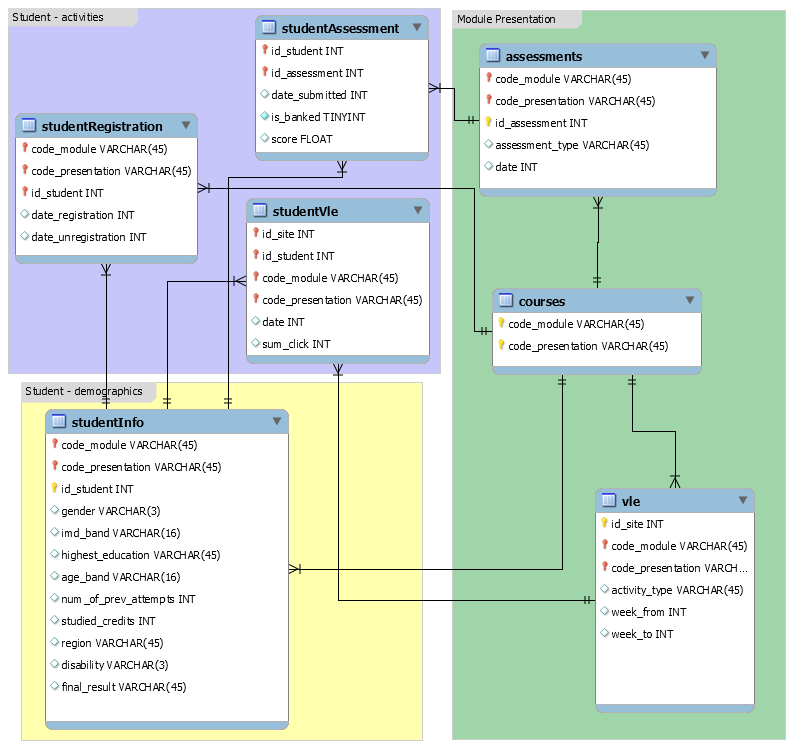

time: 4.26 ms


In [5]:
db.erd

## Preprocessing and Harness Objects

In [6]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_ohe = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector))
preprocessing_ss = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (StandardScaler(), number_selector))
sm = SMOTE(random_state=2021)

time: 1.3 ms


In [7]:
# creating accuracy scorer
accuracy = f.acc_score

# creating f1 scorer
f1 = f.f1

# creating recall scorer 
recall = f.recall

# creating precision scorer
precision = f.precision

# creating Harness
modeling = h.Harness(('accuracy', 'f1', 'recall', 'precision'))

time: 3.12 ms


## Half Term Data

In [8]:
# creating dataframe
df = db.data_prep(120)

time: 9.88 s


In [9]:
# cleaning data
drops = ['row_id', 'studied_credits',
         'id_site', 'sum_click', 'date_sub', 'date',
         'score','course_length', 'date_registration',
         'date_unregistration', 'max_date']

df = db.pipe_cleaner_wa(df, drops).reset_index(drop=True)

time: 64.8 ms


In [10]:
# saving labels as a series
final_result = df['final_result'].copy()

time: 1.37 ms


In [11]:
# dropping labels
df = df.drop('final_result', axis=1)

time: 4.01 ms


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20856 entries, 0 to 20855
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   target                20856 non-null  float64 
 1   gender                20856 non-null  object  
 2   region                20856 non-null  object  
 3   highest_education     20856 non-null  object  
 4   imd_band              20856 non-null  object  
 5   age_band              20856 non-null  object  
 6   num_of_prev_attempts  20856 non-null  float64 
 7   disability            20856 non-null  object  
 8   weighted_ave          20856 non-null  float64 
 9   mean_score            20856 non-null  float64 
 10  median_score          20856 non-null  float64 
 11  sum_activity          20856 non-null  float64 
 12  course_load           20856 non-null  category
dtypes: category(1), float64(6), object(6)
memory usage: 1.9+ MB
time: 14 ms


## Creating Holdout Data

In [13]:
# splitting data & target
X, y = f.X_y(df)

time: 3.28 ms


In [14]:
# splitting training and holdout data
X_training, X_holdout, y_training, y_holdout = f.test_train(X, y)

time: 10.1 ms


## Creating Training Data

In [15]:
# train test split
X_train, X_test, y_train, y_test = f.test_train(X_training, y_training)

time: 8.23 ms


## Loading Model

In [16]:
model = f.load_model('xgb_f1_tuned')

time: 13.5 ms


## Error Data Frame

In [17]:
y_pred = model.predict(X_test)
errors = X_test.copy()
errors['result'] = y_test
errors['prediction'] = y_pred
errors['label'] = final_result

time: 113 ms


In [18]:
errors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3911 entries, 10369 to 1645
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   gender                3911 non-null   object  
 1   region                3911 non-null   object  
 2   highest_education     3911 non-null   object  
 3   imd_band              3911 non-null   object  
 4   age_band              3911 non-null   object  
 5   num_of_prev_attempts  3911 non-null   float64 
 6   disability            3911 non-null   object  
 7   weighted_ave          3911 non-null   float64 
 8   mean_score            3911 non-null   float64 
 9   median_score          3911 non-null   float64 
 10  sum_activity          3911 non-null   float64 
 11  course_load           3911 non-null   category
 12  result                3911 non-null   float64 
 13  prediction            3911 non-null   float64 
 14  label                 3911 non-null   object  
dtype

## Numerical Feature Error Analysis

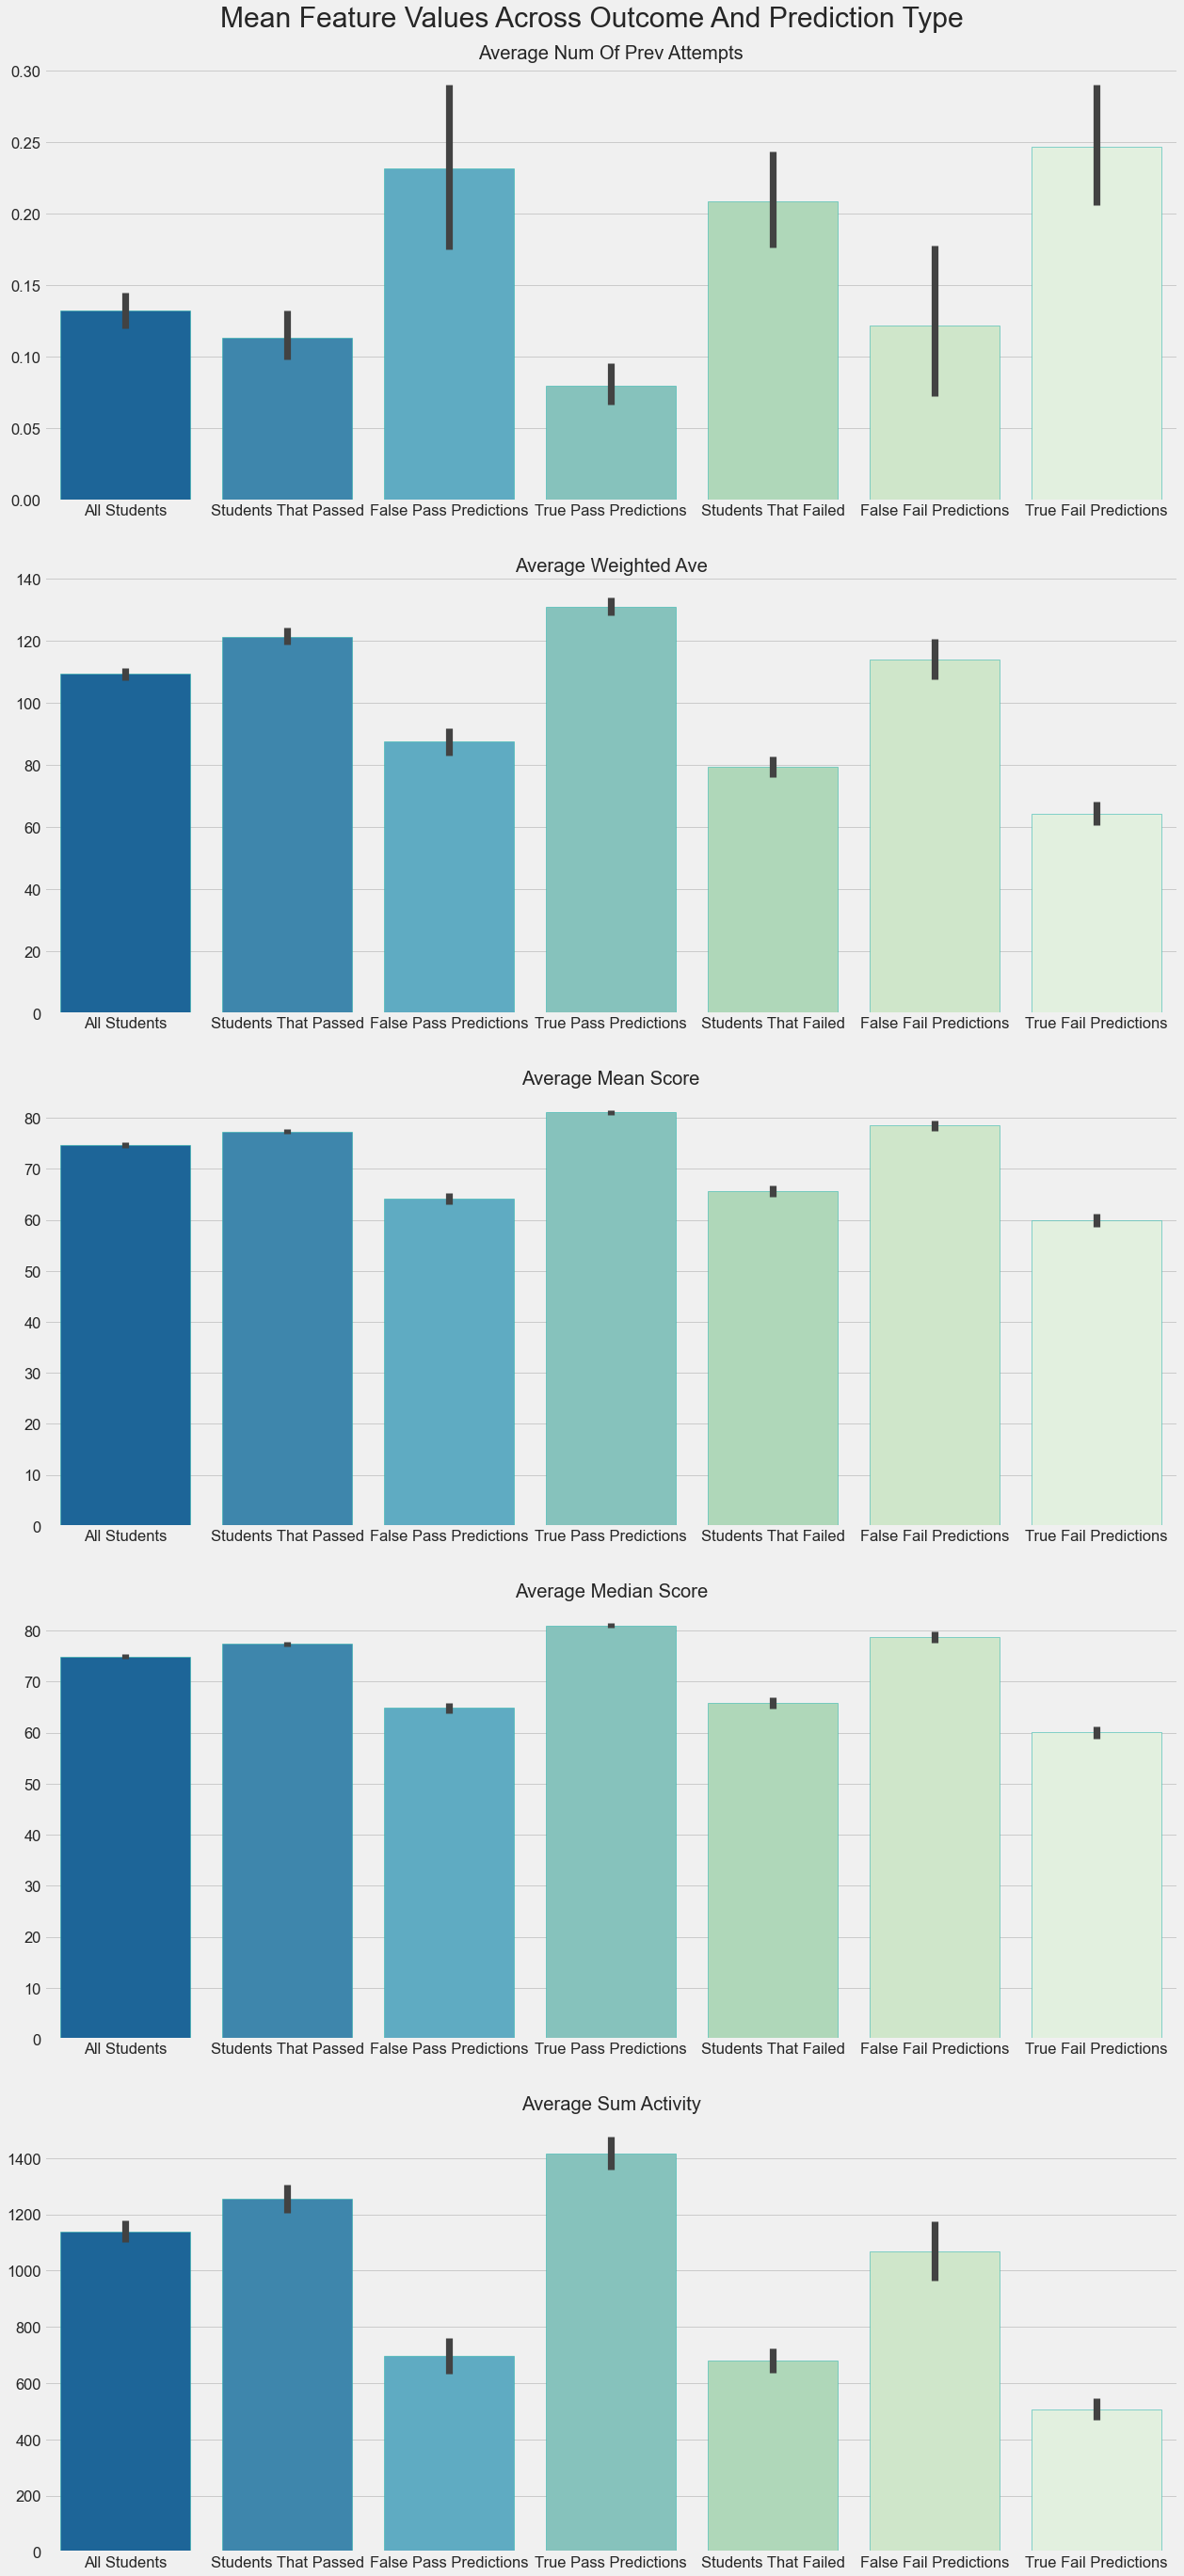

time: 1.61 s


In [21]:
num_cols = ['num_of_prev_attempts','weighted_ave','mean_score',
            'median_score','sum_activity']
v.numerical_errors(errors, num_cols)

In [28]:
num_cols = ['num_of_prev_attempts','weighted_ave','mean_score',
            'median_score','sum_activity', 'result', 'prediction', 'label']
cat_errors = errors[~errors.isin(num_cols)]

time: 11.6 ms


In [29]:
cat_errors

,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,disability,weighted_ave,mean_score,median_score,sum_activity,course_load,result,prediction,label
10369,Male,Scotland,A Level or Equivalent,90-100%,0-35,0.0,No,104.30,67.000000,66.0,582.0,Heavy,0.0,1.0,Pass
8133,Male,North Western Region,A Level or Equivalent,80-90%,0-35,0.0,No,61.50,81.500000,79.5,1195.0,Light,1.0,0.0,Withdrawn
10236,Male,South Region,HE Qualification,90-100%,0-35,1.0,No,62.50,41.000000,40.0,752.0,Medium,1.0,1.0,Fail
12232,Male,London Region,A Level or Equivalent,20-30%,0-35,0.0,No,182.07,54.142857,45.0,904.0,Medium,0.0,1.0,Pass
14979,Female,Scotland,Lower Than A Level,60-70%,35-55,1.0,No,170.00,75.142857,76.0,7259.0,Heavy,0.0,0.0,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,Female,South Region,A Level or Equivalent,90-100%,35-55,0.0,No,146.00,92.200000,96.0,312.0,Light,0.0,0.0,Pass
18839,Male,West Midlands Region,A Level or Equivalent,90-100%,0-35,1.0,No,185.00,85.500000,89.0,2178.0,Heavy,0.0,0.0,Pass
981,Female,South West Region,A Level or Equivalent,0-10%,0-35,0.0,No,102.48,75.200000,62.0,653.0,Light,0.0,0.0,Pass
20056,Female,East Anglian Region,Lower Than A Level,30-40%,0-35,0.0,No,0.00,75.333333,79.0,125.0,Light,1.0,0.0,Fail


time: 28.1 ms
